---
# Projeto I - MLP

In [1]:
# Bibliotecas utilizadas
from src.mlp import MLP

from math import ceil, log
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [2]:
def projeto(X_data:pd.DataFrame, y_data:pd.DataFrame,
        eta:list=[0.01, 0.5, 0.99], alpha:list=[0, 0.3, 0.5, 0.7, 1],
        test_size:float=0.2, n_intermed:int=1,
        neur_intermed:int=10, max_epocas:int=50, seed=386):
    fig, axs = plt.subplots(len(eta), len(alpha), sharex=True, sharey=True)
    fig.set_figheight(2*len(eta))
    fig.set_figwidth(4*len(alpha))

    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=seed, shuffle=True)
    print(f'treino:({X_train.shape}, {y_train.shape})  teste ({X_test.shape}, {y_test.shape})')

    camadas = [len(X_train[0])]
    camadas += [neur_intermed for _ in range(n_intermed)]
    camadas += [len(y_train[0])]
    print(camadas)

    for i, eta_i in enumerate(eta):
        for j, alpha_i in enumerate(alpha):
            rede = MLP(camadas=camadas,seed=seed)
            err = rede.treino(X=X_train, Y=y_train, taxa=eta_i, alpha=alpha_i, max_epocas=max_epocas)
            MSE = rede.teste(X=X_test, Y=y_test)
            axs[i,j].set_title('eta:{:.2f}    alpha:{:.2f}'.format(eta_i, alpha_i))
            axs[i,j].plot(err)
            axs[i,j].plot(len(err)-1, MSE, ls=None, marker='x', c='red')
            print('eta:{:.2f}    alpha:{:.2f}    MSE(treino):{:.5f}    MSE(teste):{:.5f}'.format(eta_i, alpha_i, err[-1], MSE))
    plt.show()

    return

In [3]:
# debug
def debug(data, X_data, y_data, tam_resp, camadas:list, n_tests:int=20,  seed:int=321):
    X_data, y_data = np.array(X_data), np.array(y_data)
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=seed, shuffle=True)
    rede = MLP(camadas=camadas)
    _ = rede.treino(X=X_data, Y=y_data, taxa=0.5, alpha=0.5, max_epocas=100)

    debug = np.random.randint(size=n_tests, low=0, high=len(data))
    for v in debug:
        debug_x = [np.array(data.iloc[v,:-tam_resp])]
        debug_y = [np.array(data.iloc[v,-tam_resp:])]
        
        saida, _ = rede.feedforward(debug_x)
        print(debug_y, saida)
    return

---
# Parte I - Classificação

---
## Tratamento Dados - Wine

---
### Importando Dados

In [4]:
cols = [
    'class', 'alcohol', 'malic acid', 'ash', 'alkalinity of ash', 'magnesium', 'total phenols',
    'flavanoids', 'nonflavanoid phenols', 'proanthocyanins', 'color intensity', 'hue', 'OD', 'proline'
]

In [5]:
# Carregando os dados em um dataframe
wine_df = pd.read_csv('data/wine.data', names=cols)
wine_df.head()

,class,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [6]:
# classificando a variavel resposta
wine_df['class'] = wine_df['class'].astype('category')
wine_df = pd.get_dummies(wine_df, columns=['class'])
wine_df.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline,class_1,class_2,class_3
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1,0,0
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,0,0
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,0,0
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,0,0
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1,0,0


In [7]:
# Verificação de valores faltantes
# Retorna "True" caso haja pelo menos uma coluna com valores faltantes na base.
# Caso contrário, retorna "False"
any(wine_df.isna().sum() > 0)

False

In [8]:
# Verificação de valores duplicados
# Retorna "True" caso haja pelo menos uma instância duplicada na base.
# Caso contrário, retorna "False"
any(wine_df.duplicated())

False

---
### Normalização

In [9]:
# Normalização dos dados
scaler = MinMaxScaler()
wine_norm = scaler.fit_transform(wine_df)
wine_norm = pd.DataFrame(wine_norm)
wine_norm.columns = wine_df.columns
wine_norm.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline,class_1,class_2,class_3
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341,1.0,0.0,0.0
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642,1.0,0.0,0.0
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933,1.0,0.0,0.0
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347,1.0,0.0,0.0
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963,1.0,0.0,0.0


---
### Separação X, y

In [10]:
# Separando as variavis explicativas da variavel resposta
wine_X = wine_norm.drop(columns=['class_1','class_2','class_3'])
wine_y = wine_norm[['class_1','class_2','class_3']]

In [11]:
wine_X.head()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
0,0.842105,0.191700,0.572193,0.257732,0.619565,0.627586,0.573840,0.283019,0.593060,0.372014,0.455285,0.970696,0.561341
1,0.571053,0.205534,0.417112,0.030928,0.326087,0.575862,0.510549,0.245283,0.274448,0.264505,0.463415,0.780220,0.550642
2,0.560526,0.320158,0.700535,0.412371,0.336957,0.627586,0.611814,0.320755,0.757098,0.375427,0.447154,0.695971,0.646933
3,0.878947,0.239130,0.609626,0.319588,0.467391,0.989655,0.664557,0.207547,0.558360,0.556314,0.308943,0.798535,0.857347
4,0.581579,0.365613,0.807487,0.536082,0.521739,0.627586,0.495781,0.490566,0.444795,0.259386,0.455285,0.608059,0.325963


In [12]:
wine_y.head()

,class_1,class_2,class_3
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [13]:
wine_X.describe()

,alcohol,malic acid,ash,alkalinity of ash,magnesium,total phenols,flavanoids,nonflavanoid phenols,proanthocyanins,color intensity,hue,OD,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,0.518584,0.315484,0.538244,0.458502,0.323278,0.453487,0.356386,0.437460,0.372523,0.322363,0.388170,0.491460,0.334446
std,0.213639,0.220780,0.146708,0.172142,0.155244,0.215811,0.210730,0.234818,0.180555,0.197806,0.185831,0.260070,0.224613
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.350658,0.170455,0.454545,0.340206,0.195652,0.262931,0.182489,0.264151,0.264984,0.165529,0.245935,0.244505,0.158702
50%,0.531579,0.222332,0.534759,0.458763,0.304348,0.474138,0.378692,0.396226,0.361199,0.290956,0.394309,0.553114,0.282097
75%,0.696711,0.462945,0.640374,0.561856,0.402174,0.627586,0.534810,0.580189,0.485804,0.419795,0.520325,0.695971,0.504280
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
wine_y.describe()

,class_1,class_2,class_3
count,178.000000,178.000000,178.000000
mean,0.331461,0.398876,0.269663
std,0.472066,0.491049,0.445037
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


---
## Aplicação

---
#### Testes com 1 camada intermediária

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 1, 3]
eta:0.01    alpha:0.00    MSE(treino):0.67092    MSE(teste):0.68546
eta:0.01    alpha:0.30    MSE(treino):0.66411    MSE(teste):0.67989
eta:0.01    alpha:0.50    MSE(treino):0.66046    MSE(teste):0.67666
eta:0.01    alpha:0.70    MSE(treino):0.65757    MSE(teste):0.67403
eta:0.01    alpha:1.00    MSE(treino):0.65462    MSE(teste):0.67125
eta:0.50    alpha:0.00    MSE(treino):0.36929    MSE(teste):0.37739
eta:0.50    alpha:0.30    MSE(treino):0.36513    MSE(teste):0.37254
eta:0.50    alpha:0.50    MSE(treino):0.36340    MSE(teste):0.37080
eta:0.50    alpha:0.70    MSE(treino):0.36358    MSE(teste):0.37097
eta:0.50    alpha:1.00    MSE(treino):0.36945    MSE(teste):0.37472
eta:0.99    alpha:0.00    MSE(treino):0.37500    MSE(teste):0.37668
eta:0.99    alpha:0.30    MSE(treino):0.38048    MSE(teste):0.38349
eta:0.99    alpha:0.50    MSE(treino):0.38287    MSE(teste):0.38739
eta:0.99    alpha:0.70    MSE(treino):0.38580    

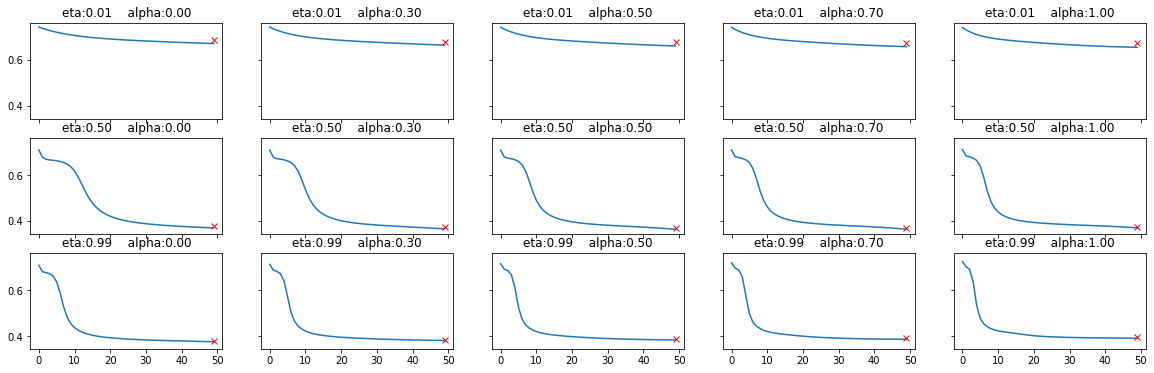

In [15]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 1, neur_intermed = 1
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 10, 3]
eta:0.01    alpha:0.00    MSE(treino):0.65321    MSE(teste):0.68114
eta:0.01    alpha:0.30    MSE(treino):0.61510    MSE(teste):0.64265
eta:0.01    alpha:0.50    MSE(treino):0.59225    MSE(teste):0.62014
eta:0.01    alpha:0.70    MSE(treino):0.57070    MSE(teste):0.59910
eta:0.01    alpha:1.00    MSE(treino):0.53984    MSE(teste):0.56900
eta:0.50    alpha:0.00    MSE(treino):0.01241    MSE(teste):0.03999
eta:0.50    alpha:0.30    MSE(treino):0.00863    MSE(teste):0.03577
eta:0.50    alpha:0.50    MSE(treino):0.00704    MSE(teste):0.03385
eta:0.50    alpha:0.70    MSE(treino):0.00587    MSE(teste):0.03241
eta:0.50    alpha:1.00    MSE(treino):0.00463    MSE(teste):0.03083
eta:0.99    alpha:0.00    MSE(treino):0.00470    MSE(teste):0.03054
eta:0.99    alpha:0.30    MSE(treino):0.00317    MSE(teste):0.02862
eta:0.99    alpha:0.50    MSE(treino):0.00256    MSE(teste):0.02792
eta:0.99    alpha:0.70    MSE(treino):0.00213   

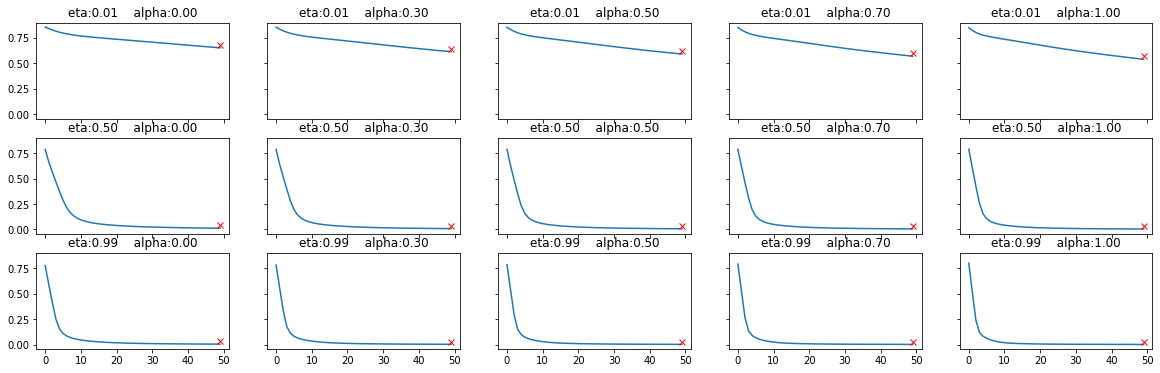

In [16]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 1, neur_intermed = 10
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 100, 3]
eta:0.01    alpha:0.00    MSE(treino):0.29606    MSE(teste):0.34057
eta:0.01    alpha:0.30    MSE(treino):0.21382    MSE(teste):0.25947
eta:0.01    alpha:0.50    MSE(treino):0.18016    MSE(teste):0.22671
eta:0.01    alpha:0.70    MSE(treino):0.15585    MSE(teste):0.20311
eta:0.01    alpha:1.00    MSE(treino):0.13016    MSE(teste):0.17809
eta:0.50    alpha:0.00    MSE(treino):0.00671    MSE(teste):0.04575
eta:0.50    alpha:0.30    MSE(treino):0.00452    MSE(teste):0.04258
eta:0.50    alpha:0.50    MSE(treino):0.00352    MSE(teste):0.04073
eta:0.50    alpha:0.70    MSE(treino):0.00284    MSE(teste):0.03786
eta:0.50    alpha:1.00    MSE(treino):0.00223    MSE(teste):0.03770
eta:0.99    alpha:0.00    MSE(treino):0.00210    MSE(teste):0.03695
eta:0.99    alpha:0.30    MSE(treino):0.00113    MSE(teste):0.03874
eta:0.99    alpha:0.50    MSE(treino):0.00104    MSE(teste):0.03413
eta:0.99    alpha:0.70    MSE(treino):0.47452  

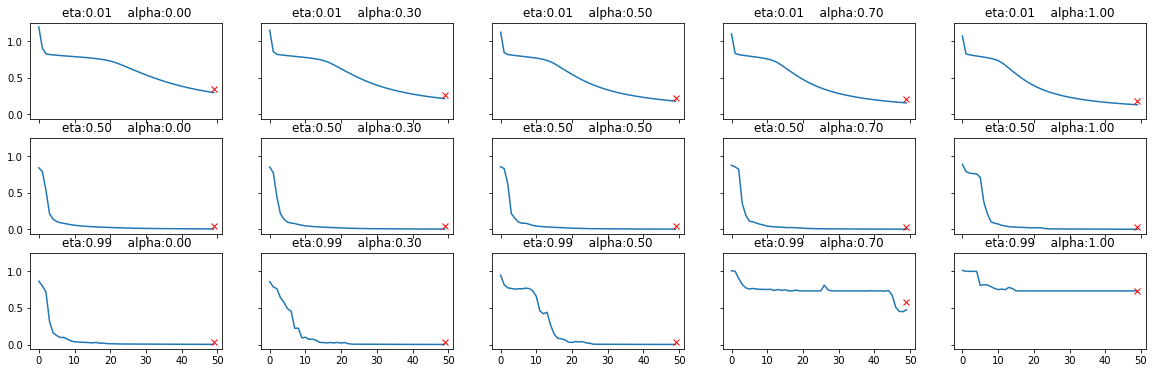

In [17]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 1, neur_intermed = 100
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 1, 3]
eta:0.01    alpha:0.00    MSE(treino):0.64929    MSE(teste):0.66639
eta:0.01    alpha:0.30    MSE(treino):0.64715    MSE(teste):0.66390
eta:0.01    alpha:0.50    MSE(treino):0.64478    MSE(teste):0.66122
eta:0.01    alpha:0.70    MSE(treino):0.64123    MSE(teste):0.65729
eta:0.01    alpha:1.00    MSE(treino):0.63246    MSE(teste):0.64771
eta:0.50    alpha:0.00    MSE(treino):0.29235    MSE(teste):0.30776
eta:0.50    alpha:0.30    MSE(treino):0.29227    MSE(teste):0.31372
eta:0.50    alpha:0.50    MSE(treino):0.29319    MSE(teste):0.31807
eta:0.50    alpha:0.70    MSE(treino):0.29458    MSE(teste):0.32315
eta:0.50    alpha:1.00    MSE(treino):0.29721    MSE(teste):0.33315
eta:0.99    alpha:0.00    MSE(treino):0.29300    MSE(teste):0.31252
eta:0.99    alpha:0.30    MSE(treino):0.31274    MSE(teste):0.31695
eta:0.99    alpha:0.50    MSE(treino):0.37672    MSE(teste):0.38783
eta:0.99    alpha:0.70    MSE(treino):0.38130    

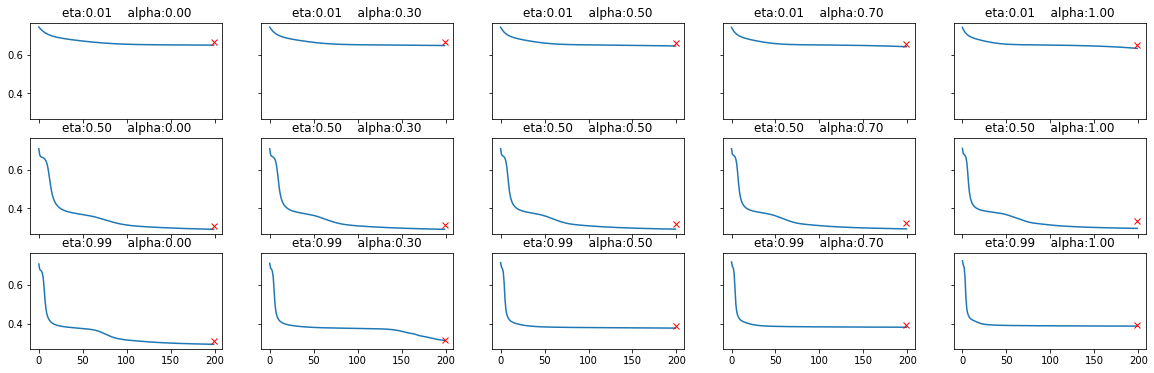

In [18]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 1, neur_intermed = 1
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 10, 3]
eta:0.01    alpha:0.00    MSE(treino):0.35058    MSE(teste):0.38730
eta:0.01    alpha:0.30    MSE(treino):0.25300    MSE(teste):0.29009
eta:0.01    alpha:0.50    MSE(treino):0.20137    MSE(teste):0.23811
eta:0.01    alpha:0.70    MSE(treino):0.16316    MSE(teste):0.19918
eta:0.01    alpha:1.00    MSE(treino):0.12460    MSE(teste):0.15949
eta:0.50    alpha:0.00    MSE(treino):0.00184    MSE(teste):0.02656
eta:0.50    alpha:0.30    MSE(treino):0.00130    MSE(teste):0.02547
eta:0.50    alpha:0.50    MSE(treino):0.00108    MSE(teste):0.02501
eta:0.50    alpha:0.70    MSE(treino):0.00092    MSE(teste):0.02468
eta:0.50    alpha:1.00    MSE(treino):0.00074    MSE(teste):0.02429
eta:0.99    alpha:0.00    MSE(treino):0.00075    MSE(teste):0.02423
eta:0.99    alpha:0.30    MSE(treino):0.00054    MSE(teste):0.02366
eta:0.99    alpha:0.50    MSE(treino):0.00045    MSE(teste):0.02347
eta:0.99    alpha:0.70    MSE(treino):0.00038   

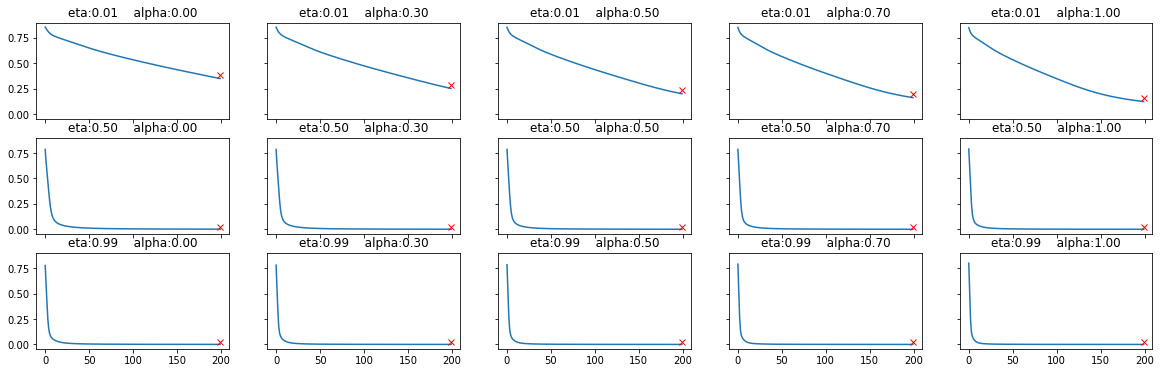

In [19]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 1, neur_intermed = 10
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 100, 3]
eta:0.01    alpha:0.00    MSE(treino):0.06543    MSE(teste):0.11429
eta:0.01    alpha:0.30    MSE(treino):0.05283    MSE(teste):0.10055
eta:0.01    alpha:0.50    MSE(treino):0.04716    MSE(teste):0.09427
eta:0.01    alpha:0.70    MSE(treino):0.04273    MSE(teste):0.08931
eta:0.01    alpha:1.00    MSE(treino):0.03760    MSE(teste):0.08346
eta:0.50    alpha:0.00    MSE(treino):0.00111    MSE(teste):0.03346
eta:0.50    alpha:0.30    MSE(treino):0.00077    MSE(teste):0.03258
eta:0.50    alpha:0.50    MSE(treino):0.00062    MSE(teste):0.03221
eta:0.50    alpha:0.70    MSE(treino):0.00052    MSE(teste):0.03046
eta:0.50    alpha:1.00    MSE(treino):0.00042    MSE(teste):0.03106
eta:0.99    alpha:0.00    MSE(treino):0.00041    MSE(teste):0.03086
eta:0.99    alpha:0.30    MSE(treino):0.00027    MSE(teste):0.03178
eta:0.99    alpha:0.50    MSE(treino):0.00022    MSE(teste):0.02881
eta:0.99    alpha:0.70    MSE(treino):0.00022  

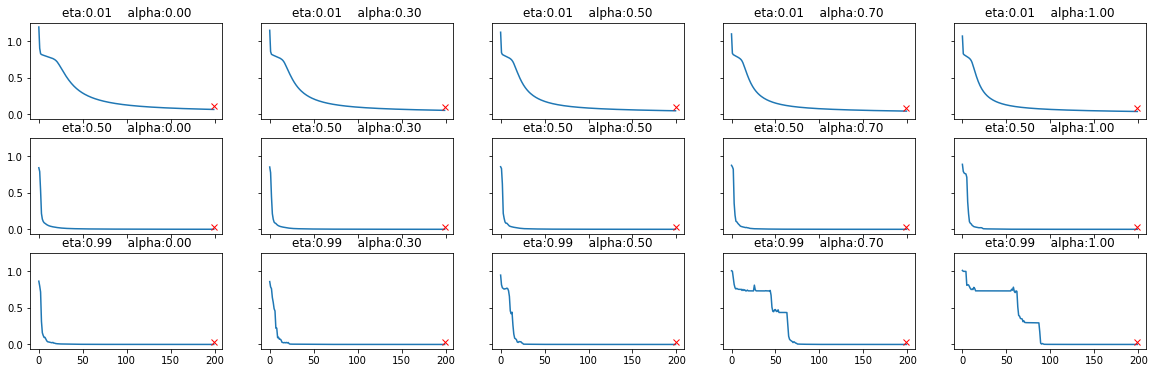

In [20]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 1, neur_intermed = 100
)

---
#### Testes com 2 camadas intermediárias

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 1, 1, 3]
eta:0.01    alpha:0.00    MSE(treino):0.66971    MSE(teste):0.70495
eta:0.01    alpha:0.30    MSE(treino):0.66187    MSE(teste):0.69237
eta:0.01    alpha:0.50    MSE(treino):0.65797    MSE(teste):0.68569
eta:0.01    alpha:0.70    MSE(treino):0.65520    MSE(teste):0.68049
eta:0.01    alpha:1.00    MSE(treino):0.65281    MSE(teste):0.67519
eta:0.50    alpha:0.00    MSE(treino):0.34010    MSE(teste):0.34973
eta:0.50    alpha:0.30    MSE(treino):0.31834    MSE(teste):0.36088
eta:0.50    alpha:0.50    MSE(treino):0.30781    MSE(teste):0.37794
eta:0.50    alpha:0.70    MSE(treino):0.30462    MSE(teste):0.38018
eta:0.50    alpha:1.00    MSE(treino):0.32856    MSE(teste):0.37951
eta:0.99    alpha:0.00    MSE(treino):0.32689    MSE(teste):0.43139
eta:0.99    alpha:0.30    MSE(treino):0.33068    MSE(teste):0.47095
eta:0.99    alpha:0.50    MSE(treino):0.35599    MSE(teste):0.35202
eta:0.99    alpha:0.70    MSE(treino):0.35605 

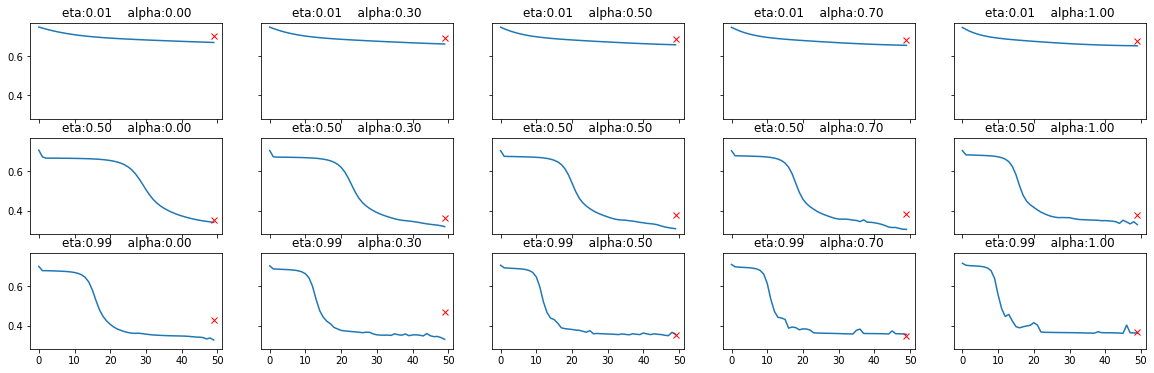

In [21]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 2, neur_intermed = 1
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 10, 10, 3]
eta:0.01    alpha:0.00    MSE(treino):0.60103    MSE(teste):0.61076
eta:0.01    alpha:0.30    MSE(treino):0.58576    MSE(teste):0.59638
eta:0.01    alpha:0.50    MSE(treino):0.57432    MSE(teste):0.58563
eta:0.01    alpha:0.70    MSE(treino):0.56181    MSE(teste):0.57390
eta:0.01    alpha:1.00    MSE(treino):0.54107    MSE(teste):0.55446
eta:0.50    alpha:0.00    MSE(treino):0.00575    MSE(teste):0.04207
eta:0.50    alpha:0.30    MSE(treino):0.00359    MSE(teste):0.03784
eta:0.50    alpha:0.50    MSE(treino):0.00279    MSE(teste):0.03619
eta:0.50    alpha:0.70    MSE(treino):0.00225    MSE(teste):0.03520
eta:0.50    alpha:1.00    MSE(treino):0.00167    MSE(teste):0.03482
eta:0.99    alpha:0.00    MSE(treino):0.00171    MSE(teste):0.03029
eta:0.99    alpha:0.30    MSE(treino):0.00103    MSE(teste):0.03126
eta:0.99    alpha:0.50    MSE(treino):0.00079    MSE(teste):0.03287
eta:0.99    alpha:0.70    MSE(treino):0.0006

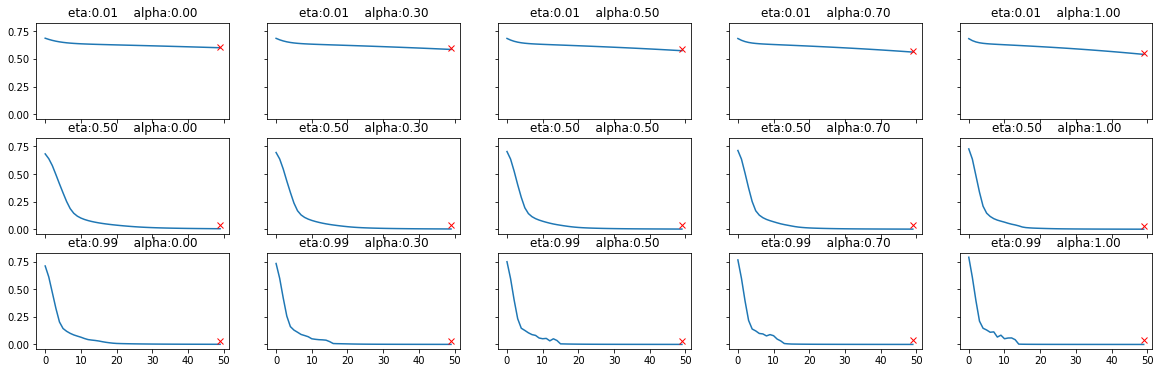

In [22]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 2, neur_intermed = 10
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 100, 100, 3]
eta:0.01    alpha:0.00    MSE(treino):0.10341    MSE(teste):0.14529
eta:0.01    alpha:0.30    MSE(treino):0.08426    MSE(teste):0.12701
eta:0.01    alpha:0.50    MSE(treino):0.07515    MSE(teste):0.11833
eta:0.01    alpha:0.70    MSE(treino):0.06791    MSE(teste):0.11137
eta:0.01    alpha:1.00    MSE(treino):0.05948    MSE(teste):0.10311
eta:0.50    alpha:0.00    MSE(treino):0.00071    MSE(teste):0.02455
eta:0.50    alpha:0.30    MSE(treino):0.00026    MSE(teste):0.02732
eta:0.50    alpha:0.50    MSE(treino):0.00017    MSE(teste):0.02680
eta:0.50    alpha:0.70    MSE(treino):0.00012    MSE(teste):0.02922
eta:0.50    alpha:1.00    MSE(treino):0.00011    MSE(teste):0.03325
eta:0.99    alpha:0.00    MSE(treino):0.00011    MSE(teste):0.02956
eta:0.99    alpha:0.30    MSE(treino):0.00001    MSE(teste):0.03055
eta:0.99    alpha:0.50    MSE(treino):0.00001    MSE(teste):0.05930
eta:0.99    alpha:0.70    MSE(treino):0.99

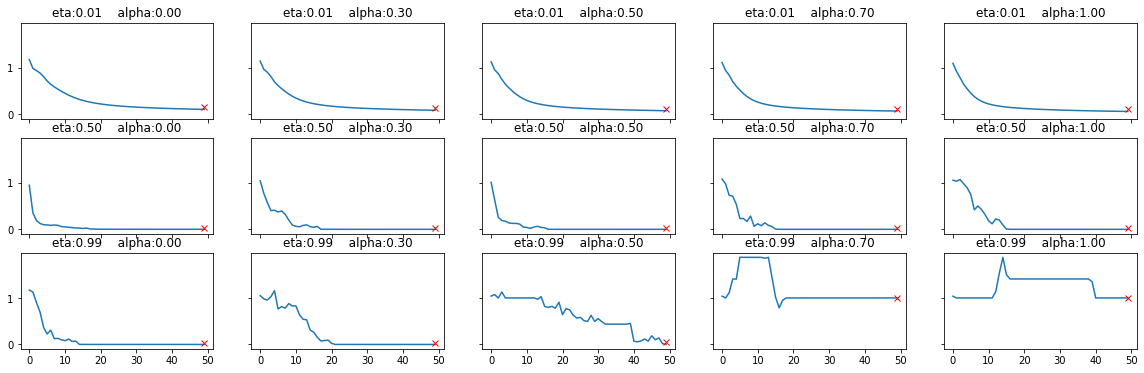

In [23]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 2, neur_intermed = 100
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 1, 1, 3]
eta:0.01    alpha:0.00    MSE(treino):0.65043    MSE(teste):0.66807
eta:0.01    alpha:0.30    MSE(treino):0.65045    MSE(teste):0.66784
eta:0.01    alpha:0.50    MSE(treino):0.65046    MSE(teste):0.66776
eta:0.01    alpha:0.70    MSE(treino):0.65046    MSE(teste):0.66768
eta:0.01    alpha:1.00    MSE(treino):0.65042    MSE(teste):0.66754
eta:0.50    alpha:0.00    MSE(treino):0.25028    MSE(teste):0.36944
eta:0.50    alpha:0.30    MSE(treino):0.25309    MSE(teste):0.36578
eta:0.50    alpha:0.50    MSE(treino):0.25993    MSE(teste):0.36545
eta:0.50    alpha:0.70    MSE(treino):0.26358    MSE(teste):0.36442
eta:0.50    alpha:1.00    MSE(treino):0.26234    MSE(teste):0.37116
eta:0.99    alpha:0.00    MSE(treino):0.29190    MSE(teste):0.33204
eta:0.99    alpha:0.30    MSE(treino):0.30818    MSE(teste):0.36815
eta:0.99    alpha:0.50    MSE(treino):0.30009    MSE(teste):0.37877
eta:0.99    alpha:0.70    MSE(treino):0.31969 

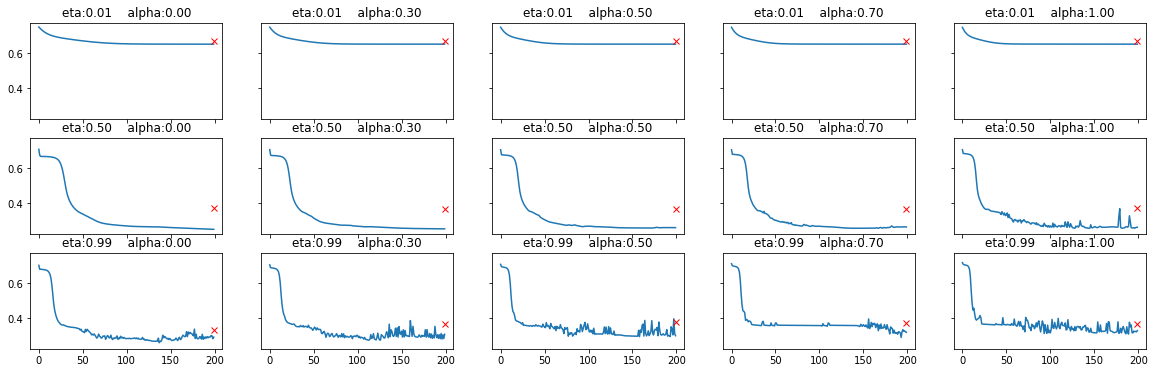

In [24]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 2, neur_intermed = 1
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 10, 10, 3]
eta:0.01    alpha:0.00    MSE(treino):0.36503    MSE(teste):0.39723
eta:0.01    alpha:0.30    MSE(treino):0.26271    MSE(teste):0.30187
eta:0.01    alpha:0.50    MSE(treino):0.20148    MSE(teste):0.24335
eta:0.01    alpha:0.70    MSE(treino):0.15463    MSE(teste):0.19819
eta:0.01    alpha:1.00    MSE(treino):0.11039    MSE(teste):0.15551
eta:0.50    alpha:0.00    MSE(treino):0.00073    MSE(teste):0.02929
eta:0.50    alpha:0.30    MSE(treino):0.00052    MSE(teste):0.02814
eta:0.50    alpha:0.50    MSE(treino):0.00043    MSE(teste):0.02780
eta:0.50    alpha:0.70    MSE(treino):0.00037    MSE(teste):0.02778
eta:0.50    alpha:1.00    MSE(treino):0.00029    MSE(teste):0.02859
eta:0.99    alpha:0.00    MSE(treino):0.00030    MSE(teste):0.02450
eta:0.99    alpha:0.30    MSE(treino):0.00021    MSE(teste):0.02629
eta:0.99    alpha:0.50    MSE(treino):0.00016    MSE(teste):0.02953
eta:0.99    alpha:0.70    MSE(treino):0.0001

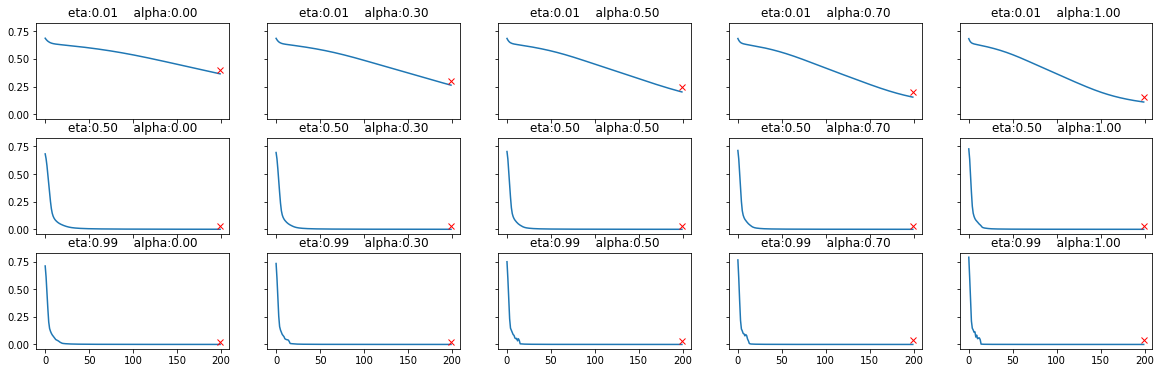

In [25]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 2, neur_intermed = 10
)

treino:((71, 13), (71, 3))  teste ((107, 13), (107, 3))
[13, 100, 100, 3]
eta:0.01    alpha:0.00    MSE(treino):0.03127    MSE(teste):0.07623
eta:0.01    alpha:0.30    MSE(treino):0.02436    MSE(teste):0.06766
eta:0.01    alpha:0.50    MSE(treino):0.02108    MSE(teste):0.06339
eta:0.01    alpha:0.70    MSE(treino):0.01851    MSE(teste):0.05996
eta:0.01    alpha:1.00    MSE(treino):0.01556    MSE(teste):0.05593
eta:0.50    alpha:0.00    MSE(treino):0.00020    MSE(teste):0.02032
eta:0.50    alpha:0.30    MSE(treino):0.00009    MSE(teste):0.02552
eta:0.50    alpha:0.50    MSE(treino):0.00006    MSE(teste):0.02538
eta:0.50    alpha:0.70    MSE(treino):0.00004    MSE(teste):0.02888
eta:0.50    alpha:1.00    MSE(treino):0.00004    MSE(teste):0.03262
eta:0.99    alpha:0.00    MSE(treino):0.00004    MSE(teste):0.02699
eta:0.99    alpha:0.30    MSE(treino):0.00001    MSE(teste):0.03020
eta:0.99    alpha:0.50    MSE(treino):0.00000    MSE(teste):0.05602
eta:0.99    alpha:0.70    MSE(treino):0.85

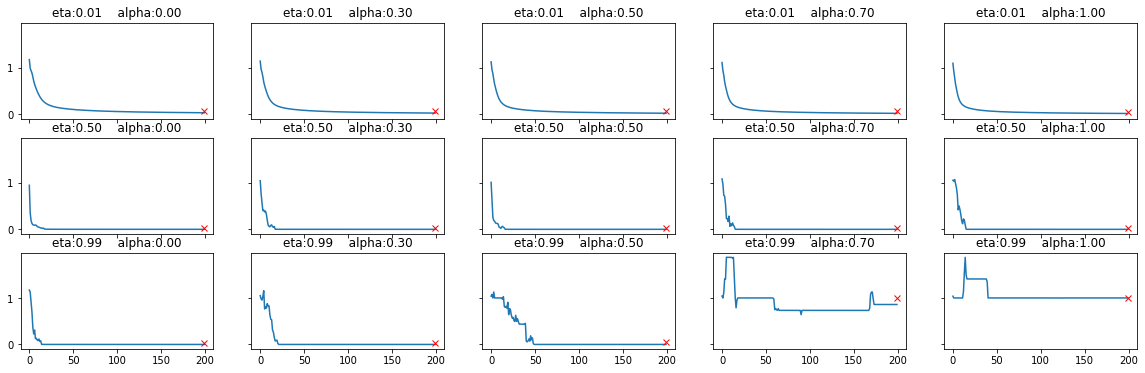

In [26]:
projeto(
    X_data = wine_X, y_data = wine_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 2, neur_intermed = 100
)

---
# Parte II - Regressão

## Tratamento Dados - Musica

As 68 primeiras colunas se referem a recursos de áudio da música, e as duas últimas se referem ao local de origem da música, representado pela latitude e longitude, respectivamente.

### Importando dados

In [27]:
# Carregando os dados em um dataframe
music_df = pd.read_csv('data/default_features_1059_tracks.txt', header=None)
music_df.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,7.161286,7.835325,2.911583,0.984049,-1.499546,-2.094097,0.576000,-1.205671,1.849122,-0.425598,...,-1.504263,0.351267,-1.018726,-0.174878,-1.089543,-0.668840,-0.914772,-0.836250,-15.75,-47.95
1,0.225763,-0.094169,-0.603646,0.497745,0.874036,0.290280,-0.077659,-0.887385,0.432062,-0.093963,...,-0.495712,-0.465077,-0.157861,-0.157189,0.380951,1.088478,-0.123595,1.391141,14.91,-23.51
2,-0.692525,-0.517801,-0.788035,1.214351,-0.907214,0.880213,0.406899,-0.694895,-0.901869,-1.701574,...,-0.637167,0.147260,0.217914,2.718442,0.972919,2.081069,1.375763,1.063847,12.65,-8.00
3,-0.735562,-0.684055,2.058215,0.716328,-0.011393,0.805396,1.497982,0.114752,0.692847,0.052377,...,-0.178325,-0.065059,-0.724247,-1.020687,-0.751380,-0.385005,-0.012326,-0.392197,9.03,38.74
4,0.570272,0.273157,-0.279214,0.083456,1.049331,-0.869295,-0.265858,-0.401676,-0.872639,1.147483,...,-0.919463,-0.667912,-0.820172,-0.190488,0.306974,0.119658,0.271838,1.289783,34.03,-6.85


In [28]:
# Verificação de valores faltantes
# Retorna "True" caso haja pelo menos uma coluna com valores faltantes na base.
# Caso contrário, retorna "False"
any(music_df.isna().sum() > 0)

False

In [29]:
# Verificação de valores duplicados
# Retorna "True" caso haja pelo menos uma instância duplicada na base.
# Caso contrário, retorna "False"
any(music_df.duplicated())

False

---
### Normalização

In [30]:
music_scaler = MinMaxScaler()
music_norm = music_scaler.fit_transform(music_df)
music_norm = pd.DataFrame(music_norm)
music_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,60,61,62,63,64,65,66,67,68,69
0,0.792304,0.763528,0.554789,0.459774,0.332975,0.312870,0.694223,0.485061,0.772537,0.621409,...,0.010367,0.279176,0.059900,0.180836,0.046037,0.075438,0.046425,0.067519,0.217271,0.171557
1,0.160018,0.113349,0.072690,0.406624,0.751846,0.641129,0.601004,0.522885,0.619012,0.653455,...,0.122493,0.161148,0.146472,0.183240,0.260799,0.304061,0.166138,0.372358,0.558013,0.274298
2,0.076301,0.078613,0.047402,0.484945,0.437505,0.722346,0.670107,0.545760,0.474494,0.498113,...,0.106767,0.249681,0.184261,0.573916,0.347254,0.433194,0.393006,0.327565,0.532896,0.339499
3,0.072377,0.064981,0.437753,0.430514,0.595593,0.712046,0.825708,0.641975,0.647266,0.667595,...,0.157779,0.218983,0.089514,0.065927,0.095425,0.112365,0.182974,0.128292,0.492665,0.535985
4,0.191425,0.143468,0.117185,0.361344,0.782781,0.481490,0.574164,0.580605,0.477661,0.773414,...,0.075383,0.131821,0.079867,0.178716,0.249995,0.178020,0.225971,0.358486,0.770505,0.344333


---
### Separando X, y

In [31]:
# Separando os atributos
music_X = music_norm.drop(columns=[68,69])
music_y = music_norm[[68,69]]

In [32]:
music_X.head()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
0,0.792304,0.763528,0.554789,0.459774,0.332975,0.312870,0.694223,0.485061,0.772537,0.621409,...,0.080394,0.252689,0.010367,0.279176,0.059900,0.180836,0.046037,0.075438,0.046425,0.067519
1,0.160018,0.113349,0.072690,0.406624,0.751846,0.641129,0.601004,0.522885,0.619012,0.653455,...,0.213051,0.111763,0.122493,0.161148,0.146472,0.183240,0.260799,0.304061,0.166138,0.372358
2,0.076301,0.078613,0.047402,0.484945,0.437505,0.722346,0.670107,0.545760,0.474494,0.498113,...,0.102961,0.172823,0.106767,0.249681,0.184261,0.573916,0.347254,0.433194,0.393006,0.327565
3,0.072377,0.064981,0.437753,0.430514,0.595593,0.712046,0.825708,0.641975,0.647266,0.667595,...,0.101781,0.285450,0.157779,0.218983,0.089514,0.065927,0.095425,0.112365,0.182974,0.128292
4,0.191425,0.143468,0.117185,0.361344,0.782781,0.481490,0.574164,0.580605,0.477661,0.773414,...,0.198040,0.181444,0.075383,0.131821,0.079867,0.178716,0.249995,0.178020,0.225971,0.358486


In [33]:
music_y.head()

,68,69
0,0.217271,0.171557
1,0.558013,0.274298
2,0.532896,0.339499
3,0.492665,0.535985
4,0.770505,0.344333


In [34]:
music_X.describe()

,0,1,2,3,4,5,6,7,8,9,...,58,59,60,61,62,63,64,65,66,67
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,...,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,0.137675,0.119341,0.151387,0.347702,0.602079,0.601651,0.609058,0.629529,0.568848,0.660844,...,0.228568,0.263354,0.180476,0.231270,0.164924,0.207457,0.209170,0.165028,0.188380,0.185051
std,0.090064,0.080855,0.133417,0.107610,0.176360,0.137713,0.141061,0.119754,0.109147,0.098285,...,0.154851,0.158662,0.112526,0.146001,0.101449,0.135914,0.146102,0.130498,0.152983,0.137820
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.084041,0.070085,0.073296,0.282204,0.491777,0.513916,0.525338,0.562216,0.516567,0.617680,...,0.116240,0.146175,0.103242,0.130004,0.092673,0.114911,0.103892,0.077568,0.087802,0.091801
50%,0.122649,0.103749,0.114154,0.337469,0.625379,0.602785,0.617482,0.633383,0.580264,0.671376,...,0.187502,0.224180,0.154504,0.198967,0.144016,0.178620,0.170406,0.129550,0.137078,0.140347
75%,0.167894,0.146520,0.177241,0.402418,0.727464,0.692378,0.703896,0.696590,0.635436,0.717582,...,0.297618,0.345902,0.229485,0.298629,0.211424,0.269267,0.276279,0.204955,0.247677,0.230231
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
music_y.describe()

,68,69
count,1059.000000,1059.000000
mean,0.688501,0.534579
std,0.205150,0.211955
min,0.000000,0.000000
25%,0.555234,0.386624
50%,0.766393,0.511140
75%,0.835852,0.686733
max,1.000000,1.000000


---
## Aplicação

---
### 1 camada

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 1, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08891    MSE(teste):0.08697
eta:0.01    alpha:0.30    MSE(treino):0.08881    MSE(teste):0.08686
eta:0.01    alpha:0.50    MSE(treino):0.08875    MSE(teste):0.08680
eta:0.01    alpha:0.70    MSE(treino):0.08871    MSE(teste):0.08675
eta:0.01    alpha:1.00    MSE(treino):0.08866    MSE(teste):0.08669
eta:0.50    alpha:0.00    MSE(treino):0.08938    MSE(teste):0.08728
eta:0.50    alpha:0.30    MSE(treino):0.08968    MSE(teste):0.08738
eta:0.50    alpha:0.50    MSE(treino):0.08989    MSE(teste):0.08736
eta:0.50    alpha:0.70    MSE(treino):0.09011    MSE(teste):0.08730
eta:0.50    alpha:1.00    MSE(treino):0.09046    MSE(teste):0.08717
eta:0.99    alpha:0.00    MSE(treino):0.09064    MSE(teste):0.08720
eta:0.99    alpha:0.30    MSE(treino):0.09131    MSE(teste):0.08695
eta:0.99    alpha:0.50    MSE(treino):0.09177    MSE(teste):0.08683
eta:0.99    alpha:0.70    MSE(treino):0.09226  

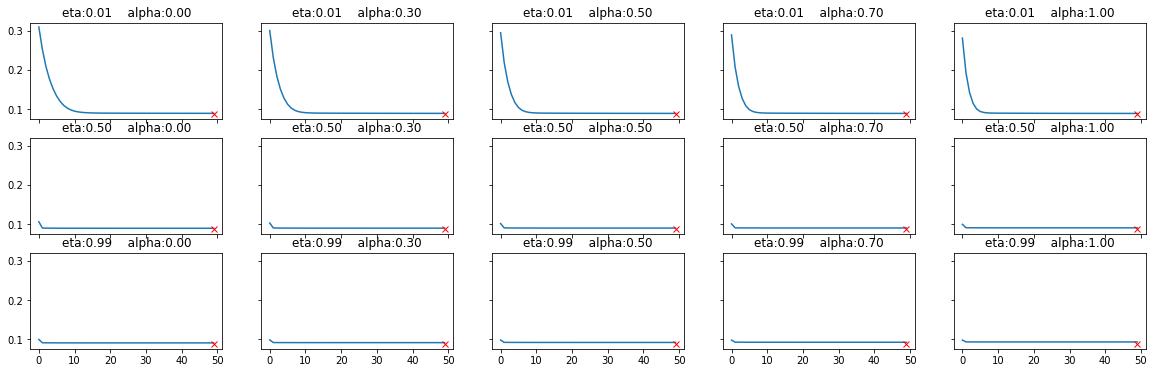

In [36]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 1, neur_intermed = 1
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 10, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08854    MSE(teste):0.08904
eta:0.01    alpha:0.30    MSE(treino):0.08612    MSE(teste):0.08736
eta:0.01    alpha:0.50    MSE(treino):0.08492    MSE(teste):0.08656
eta:0.01    alpha:0.70    MSE(treino):0.08392    MSE(teste):0.08591
eta:0.01    alpha:1.00    MSE(treino):0.08269    MSE(teste):0.08515
eta:0.50    alpha:0.00    MSE(treino):0.05801    MSE(teste):0.07692
eta:0.50    alpha:0.30    MSE(treino):0.05586    MSE(teste):0.07670
eta:0.50    alpha:0.50    MSE(treino):0.05480    MSE(teste):0.07673
eta:0.50    alpha:0.70    MSE(treino):0.05396    MSE(teste):0.07688
eta:0.50    alpha:1.00    MSE(treino):0.05300    MSE(teste):0.07730
eta:0.99    alpha:0.00    MSE(treino):0.05350    MSE(teste):0.07761
eta:0.99    alpha:0.30    MSE(treino):0.05215    MSE(teste):0.07847
eta:0.99    alpha:0.50    MSE(treino):0.05173    MSE(teste):0.07917
eta:0.99    alpha:0.70    MSE(treino):0.05162 

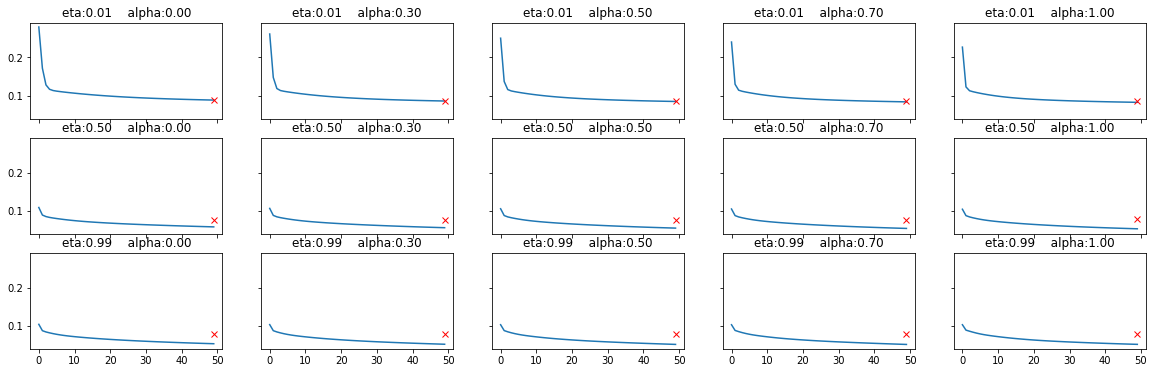

In [37]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 1, neur_intermed = 10
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 100, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08577    MSE(teste):0.10280
eta:0.01    alpha:0.30    MSE(treino):0.08083    MSE(teste):0.09885
eta:0.01    alpha:0.50    MSE(treino):0.07830    MSE(teste):0.09685
eta:0.01    alpha:0.70    MSE(treino):0.07620    MSE(teste):0.09520
eta:0.01    alpha:1.00    MSE(treino):0.07364    MSE(teste):0.09323
eta:0.50    alpha:0.00    MSE(treino):0.05793    MSE(teste):0.10593
eta:0.50    alpha:0.30    MSE(treino):0.05346    MSE(teste):0.12027
eta:0.50    alpha:0.50    MSE(treino):0.05422    MSE(teste):0.13595
eta:0.50    alpha:0.70    MSE(treino):0.05198    MSE(teste):0.14252
eta:0.50    alpha:1.00    MSE(treino):0.04815    MSE(teste):0.11691
eta:0.99    alpha:0.00    MSE(treino):0.04734    MSE(teste):0.10049
eta:0.99    alpha:0.30    MSE(treino):0.04104    MSE(teste):0.09852
eta:0.99    alpha:0.50    MSE(treino):0.04094    MSE(teste):0.10395
eta:0.99    alpha:0.70    MSE(treino):0.03883

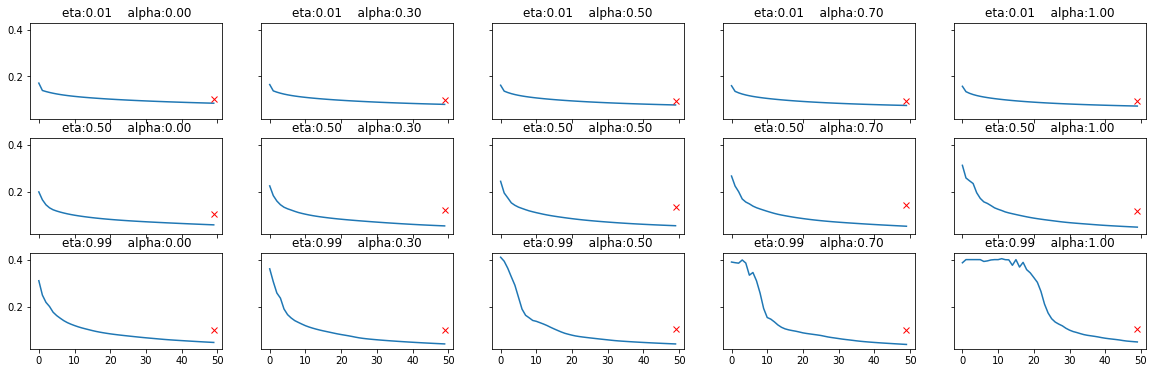

In [38]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 1, neur_intermed = 100
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 1, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08841    MSE(teste):0.08647
eta:0.01    alpha:0.30    MSE(treino):0.08836    MSE(teste):0.08641
eta:0.01    alpha:0.50    MSE(treino):0.08834    MSE(teste):0.08638
eta:0.01    alpha:0.70    MSE(treino):0.08833    MSE(teste):0.08636
eta:0.01    alpha:1.00    MSE(treino):0.08832    MSE(teste):0.08634
eta:0.50    alpha:0.00    MSE(treino):0.08936    MSE(teste):0.08726
eta:0.50    alpha:0.30    MSE(treino):0.08966    MSE(teste):0.08736
eta:0.50    alpha:0.50    MSE(treino):0.08988    MSE(teste):0.08735
eta:0.50    alpha:0.70    MSE(treino):0.09010    MSE(teste):0.08729
eta:0.50    alpha:1.00    MSE(treino):0.09045    MSE(teste):0.08716
eta:0.99    alpha:0.00    MSE(treino):0.09063    MSE(teste):0.08719
eta:0.99    alpha:0.30    MSE(treino):0.09130    MSE(teste):0.08694
eta:0.99    alpha:0.50    MSE(treino):0.09176    MSE(teste):0.08682
eta:0.99    alpha:0.70    MSE(treino):0.09225  

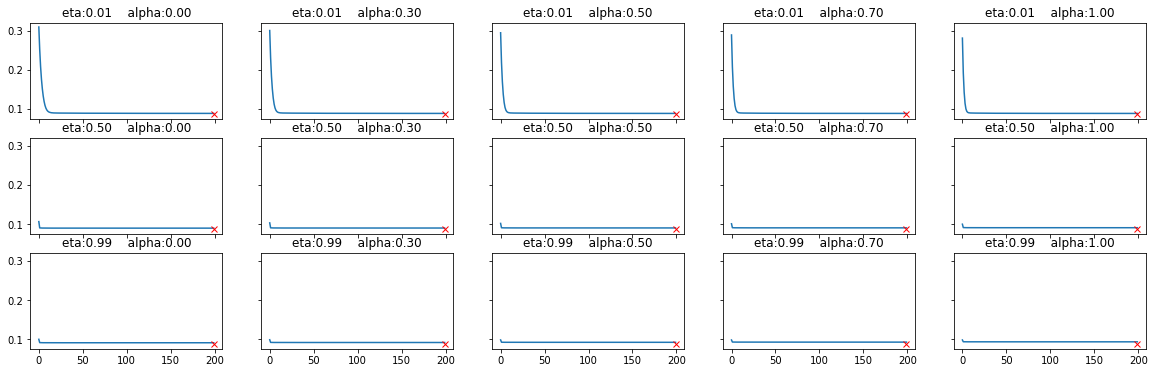

In [39]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 1, neur_intermed = 1
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 10, 2]
eta:0.01    alpha:0.00    MSE(treino):0.07759    MSE(teste):0.08277
eta:0.01    alpha:0.30    MSE(treino):0.07562    MSE(teste):0.08206
eta:0.01    alpha:0.50    MSE(treino):0.07447    MSE(teste):0.08165
eta:0.01    alpha:0.70    MSE(treino):0.07341    MSE(teste):0.08128
eta:0.01    alpha:1.00    MSE(treino):0.07199    MSE(teste):0.08078
eta:0.50    alpha:0.00    MSE(treino):0.03893    MSE(teste):0.08361
eta:0.50    alpha:0.30    MSE(treino):0.03581    MSE(teste):0.08687
eta:0.50    alpha:0.50    MSE(treino):0.03408    MSE(teste):0.08913
eta:0.50    alpha:0.70    MSE(treino):0.03273    MSE(teste):0.09130
eta:0.50    alpha:1.00    MSE(treino):0.03133    MSE(teste):0.09381
eta:0.99    alpha:0.00    MSE(treino):0.03217    MSE(teste):0.09270
eta:0.99    alpha:0.30    MSE(treino):0.03094    MSE(teste):0.09233
eta:0.99    alpha:0.50    MSE(treino):0.03056    MSE(teste):0.09295
eta:0.99    alpha:0.70    MSE(treino):0.02977 

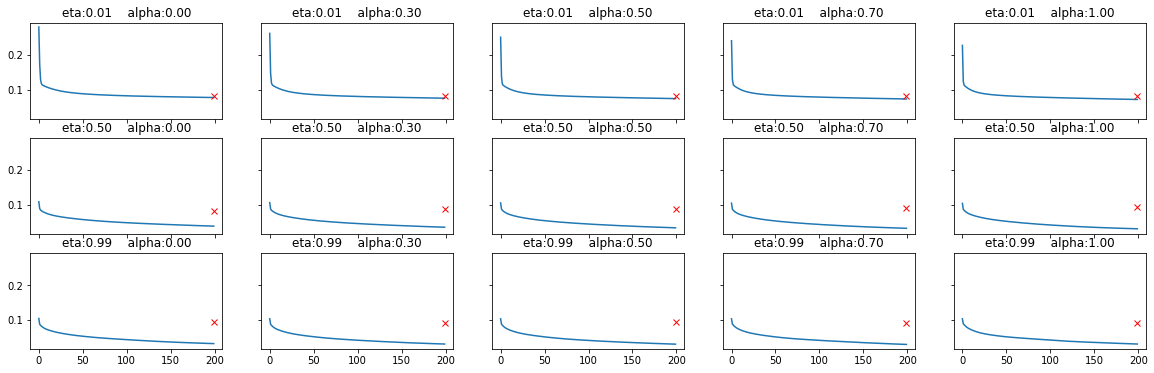

In [40]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 1, neur_intermed = 10
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 100, 2]
eta:0.01    alpha:0.00    MSE(treino):0.06224    MSE(teste):0.08576
eta:0.01    alpha:0.30    MSE(treino):0.05885    MSE(teste):0.08419
eta:0.01    alpha:0.50    MSE(treino):0.05712    MSE(teste):0.08350
eta:0.01    alpha:0.70    MSE(treino):0.05567    MSE(teste):0.08296
eta:0.01    alpha:1.00    MSE(treino):0.05388    MSE(teste):0.08235
eta:0.50    alpha:0.00    MSE(treino):0.01788    MSE(teste):0.10284
eta:0.50    alpha:0.30    MSE(treino):0.01456    MSE(teste):0.10576
eta:0.50    alpha:0.50    MSE(treino):0.01257    MSE(teste):0.10563
eta:0.50    alpha:0.70    MSE(treino):0.01004    MSE(teste):0.10409
eta:0.50    alpha:1.00    MSE(treino):0.00873    MSE(teste):0.10668
eta:0.99    alpha:0.00    MSE(treino):0.00954    MSE(teste):0.10235
eta:0.99    alpha:0.30    MSE(treino):0.00739    MSE(teste):0.10424
eta:0.99    alpha:0.50    MSE(treino):0.00654    MSE(teste):0.10496
eta:0.99    alpha:0.70    MSE(treino):0.00552

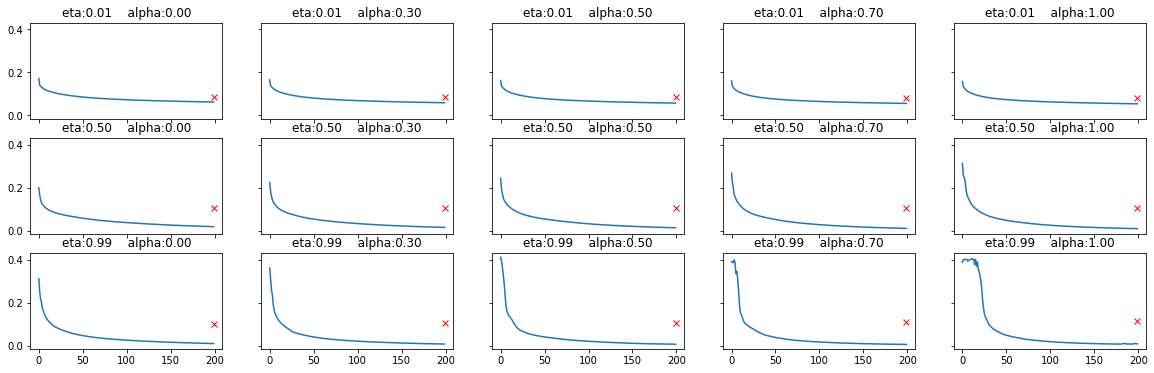

In [41]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 1, neur_intermed = 100
)

---
### 2 camadas

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 1, 1, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08815    MSE(teste):0.08616
eta:0.01    alpha:0.30    MSE(treino):0.08817    MSE(teste):0.08616
eta:0.01    alpha:0.50    MSE(treino):0.08818    MSE(teste):0.08616
eta:0.01    alpha:0.70    MSE(treino):0.08820    MSE(teste):0.08617
eta:0.01    alpha:1.00    MSE(treino):0.08821    MSE(teste):0.08617
eta:0.50    alpha:0.00    MSE(treino):0.07535    MSE(teste):0.08049
eta:0.50    alpha:0.30    MSE(treino):0.07269    MSE(teste):0.07879
eta:0.50    alpha:0.50    MSE(treino):0.07188    MSE(teste):0.07903
eta:0.50    alpha:0.70    MSE(treino):0.07139    MSE(teste):0.07961
eta:0.50    alpha:1.00    MSE(treino):0.07101    MSE(teste):0.08056
eta:0.99    alpha:0.00    MSE(treino):0.07122    MSE(teste):0.07991
eta:0.99    alpha:0.30    MSE(treino):0.07101    MSE(teste):0.08167
eta:0.99    alpha:0.50    MSE(treino):0.07113    MSE(teste):0.08264
eta:0.99    alpha:0.70    MSE(treino):0.0713

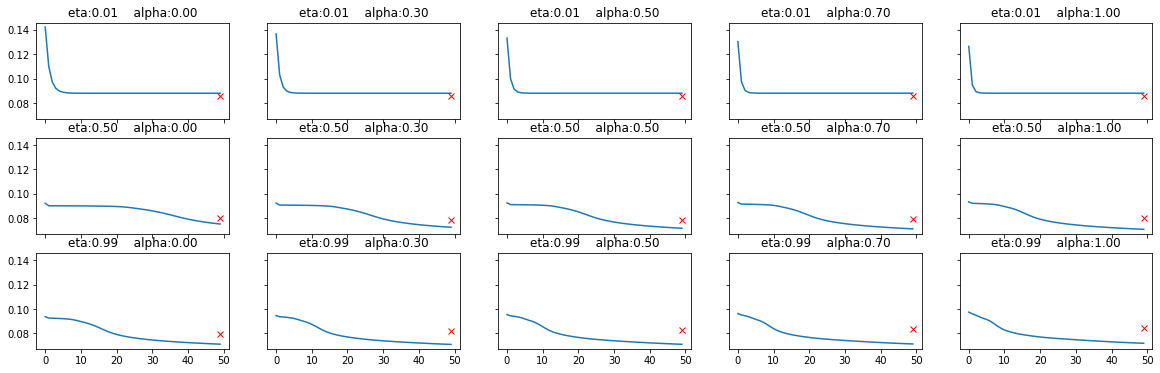

In [42]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 2, neur_intermed = 1
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 10, 10, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08310    MSE(teste):0.08272
eta:0.01    alpha:0.30    MSE(treino):0.08183    MSE(teste):0.08188
eta:0.01    alpha:0.50    MSE(treino):0.08107    MSE(teste):0.08139
eta:0.01    alpha:0.70    MSE(treino):0.08035    MSE(teste):0.08095
eta:0.01    alpha:1.00    MSE(treino):0.07936    MSE(teste):0.08037
eta:0.50    alpha:0.00    MSE(treino):0.05846    MSE(teste):0.07513
eta:0.50    alpha:0.30    MSE(treino):0.05681    MSE(teste):0.07501
eta:0.50    alpha:0.50    MSE(treino):0.05582    MSE(teste):0.07485
eta:0.50    alpha:0.70    MSE(treino):0.05514    MSE(teste):0.07465
eta:0.50    alpha:1.00    MSE(treino):0.05462    MSE(teste):0.07473
eta:0.99    alpha:0.00    MSE(treino):0.05488    MSE(teste):0.07503
eta:0.99    alpha:0.30    MSE(treino):0.05375    MSE(teste):0.07598
eta:0.99    alpha:0.50    MSE(treino):0.05299    MSE(teste):0.07705
eta:0.99    alpha:0.70    MSE(treino):0.05

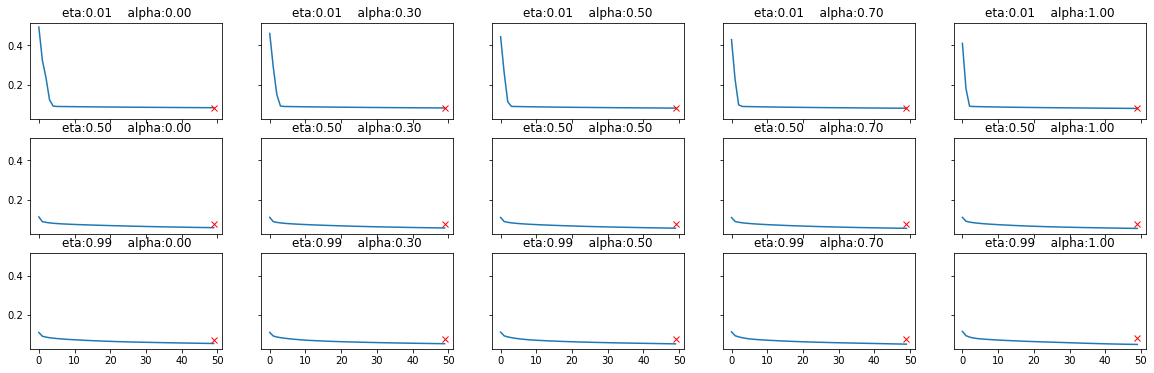

In [43]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 2, neur_intermed = 10
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 100, 100, 2]
eta:0.01    alpha:0.00    MSE(treino):0.06866    MSE(teste):0.08446
eta:0.01    alpha:0.30    MSE(treino):0.06595    MSE(teste):0.08303
eta:0.01    alpha:0.50    MSE(treino):0.06470    MSE(teste):0.08246
eta:0.01    alpha:0.70    MSE(treino):0.06368    MSE(teste):0.08205
eta:0.01    alpha:1.00    MSE(treino):0.06241    MSE(teste):0.08160
eta:0.50    alpha:0.00    MSE(treino):0.04061    MSE(teste):0.10660
eta:0.50    alpha:0.30    MSE(treino):0.05144    MSE(teste):0.13662
eta:0.50    alpha:0.50    MSE(treino):0.04611    MSE(teste):0.13076
eta:0.50    alpha:0.70    MSE(treino):0.04652    MSE(teste):0.12317
eta:0.50    alpha:1.00    MSE(treino):0.04903    MSE(teste):0.11018
eta:0.99    alpha:0.00    MSE(treino):0.06241    MSE(teste):0.11164
eta:0.99    alpha:0.30    MSE(treino):0.05455    MSE(teste):0.12512
eta:0.99    alpha:0.50    MSE(treino):0.05810    MSE(teste):0.12947
eta:0.99    alpha:0.70    MSE(treino):0.

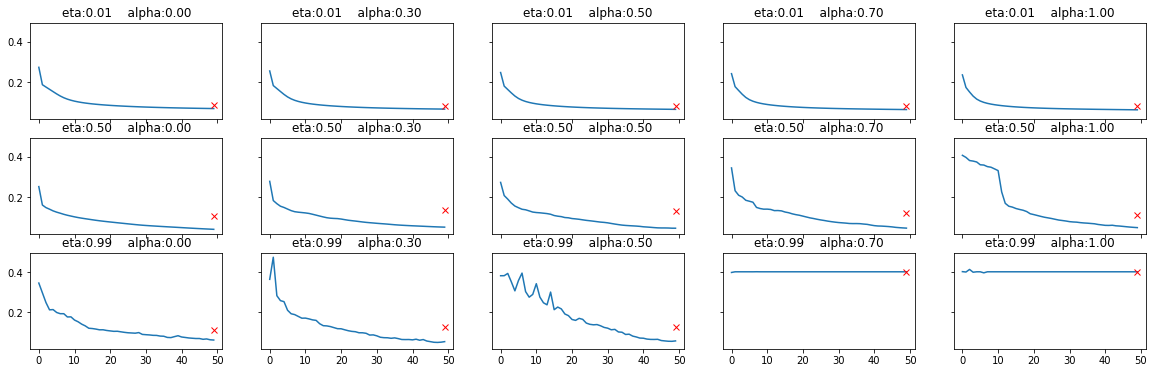

In [44]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 50,
    n_intermed= 2, neur_intermed = 100
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 1, 1, 2]
eta:0.01    alpha:0.00    MSE(treino):0.08815    MSE(teste):0.08616
eta:0.01    alpha:0.30    MSE(treino):0.08816    MSE(teste):0.08616
eta:0.01    alpha:0.50    MSE(treino):0.08818    MSE(teste):0.08616
eta:0.01    alpha:0.70    MSE(treino):0.08819    MSE(teste):0.08616
eta:0.01    alpha:1.00    MSE(treino):0.08820    MSE(teste):0.08616
eta:0.50    alpha:0.00    MSE(treino):0.06569    MSE(teste):0.08101
eta:0.50    alpha:0.30    MSE(treino):0.06542    MSE(teste):0.08220
eta:0.50    alpha:0.50    MSE(treino):0.06532    MSE(teste):0.08280
eta:0.50    alpha:0.70    MSE(treino):0.06527    MSE(teste):0.08328
eta:0.50    alpha:1.00    MSE(treino):0.06529    MSE(teste):0.08387
eta:0.99    alpha:0.00    MSE(treino):0.06568    MSE(teste):0.08345
eta:0.99    alpha:0.30    MSE(treino):0.06569    MSE(teste):0.08465
eta:0.99    alpha:0.50    MSE(treino):0.06576    MSE(teste):0.08572
eta:0.99    alpha:0.70    MSE(treino):0.0659

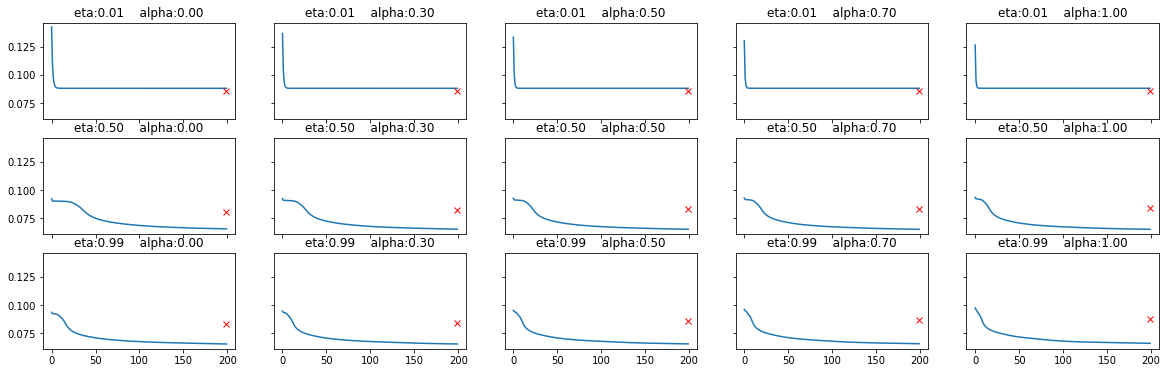

In [45]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 2, neur_intermed = 1
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 10, 10, 2]
eta:0.01    alpha:0.00    MSE(treino):0.07423    MSE(teste):0.07820
eta:0.01    alpha:0.30    MSE(treino):0.07254    MSE(teste):0.07800
eta:0.01    alpha:0.50    MSE(treino):0.07166    MSE(teste):0.07800
eta:0.01    alpha:0.70    MSE(treino):0.07090    MSE(teste):0.07802
eta:0.01    alpha:1.00    MSE(treino):0.06994    MSE(teste):0.07806
eta:0.50    alpha:0.00    MSE(treino):0.03687    MSE(teste):0.08113
eta:0.50    alpha:0.30    MSE(treino):0.03421    MSE(teste):0.07825
eta:0.50    alpha:0.50    MSE(treino):0.03143    MSE(teste):0.08069
eta:0.50    alpha:0.70    MSE(treino):0.03091    MSE(teste):0.08355
eta:0.50    alpha:1.00    MSE(treino):0.02771    MSE(teste):0.08914
eta:0.99    alpha:0.00    MSE(treino):0.02699    MSE(teste):0.08653
eta:0.99    alpha:0.30    MSE(treino):0.02459    MSE(teste):0.09355
eta:0.99    alpha:0.50    MSE(treino):0.02475    MSE(teste):0.09808
eta:0.99    alpha:0.70    MSE(treino):0.02

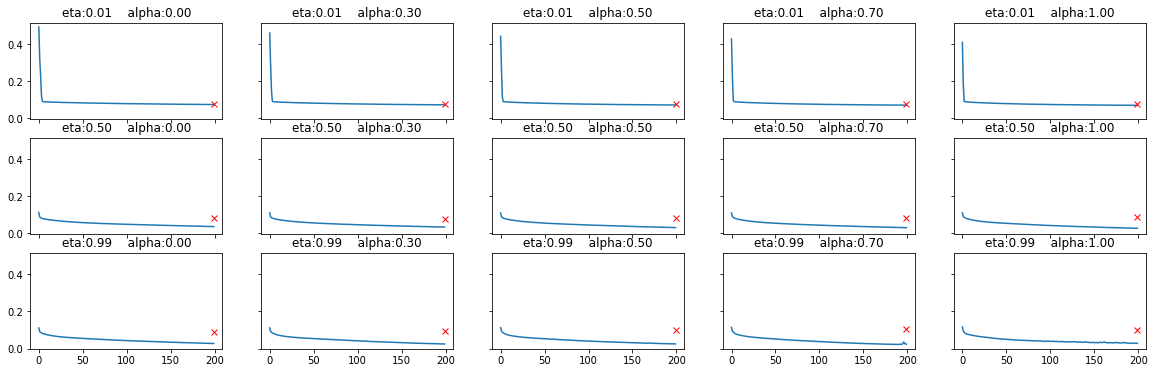

In [46]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 2, neur_intermed = 10
)

treino:((423, 68), (423, 2))  teste ((636, 68), (636, 2))
[68, 100, 100, 2]
eta:0.01    alpha:0.00    MSE(treino):0.05438    MSE(teste):0.07936
eta:0.01    alpha:0.30    MSE(treino):0.05113    MSE(teste):0.07930
eta:0.01    alpha:0.50    MSE(treino):0.04924    MSE(teste):0.07933
eta:0.01    alpha:0.70    MSE(treino):0.04751    MSE(teste):0.07939
eta:0.01    alpha:1.00    MSE(treino):0.04519    MSE(teste):0.07955
eta:0.50    alpha:0.00    MSE(treino):0.00703    MSE(teste):0.10986
eta:0.50    alpha:0.30    MSE(treino):0.01149    MSE(teste):0.11079
eta:0.50    alpha:0.50    MSE(treino):0.00648    MSE(teste):0.11553
eta:0.50    alpha:0.70    MSE(treino):0.00791    MSE(teste):0.10085
eta:0.50    alpha:1.00    MSE(treino):0.00652    MSE(teste):0.10794
eta:0.99    alpha:0.00    MSE(treino):0.00625    MSE(teste):0.09996
eta:0.99    alpha:0.30    MSE(treino):0.00462    MSE(teste):0.11341
eta:0.99    alpha:0.50    MSE(treino):0.00666    MSE(teste):0.09592
eta:0.99    alpha:0.70    MSE(treino):0.

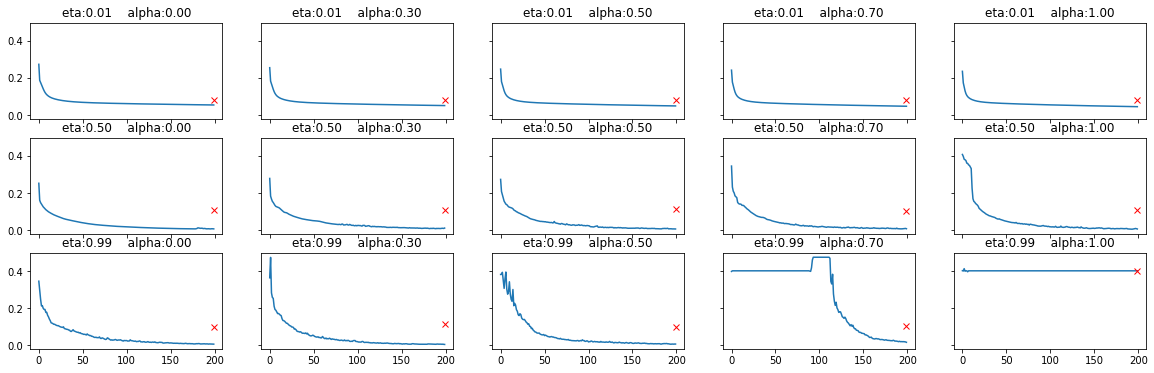

In [47]:
projeto(
    X_data = music_X, y_data = music_y,
    test_size = 0.6, max_epocas = 200,
    n_intermed= 2, neur_intermed = 100
)